In [3]:
# Let's import some basic packages

import numpy as np
import scipy
import scipy.spatial
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Tutorial 5 - Connectome Spectral Analysis

In this tutorial we will learn how to decompose time-series of brain activity into a time-varying weighted composition of connectome harmonics. 
See refs: 
- Glomb et al. Neuroimage (2020) 
- Rué-Queralt et al. NeuroImage (2021)

Some of the content in this notebook was inspired from https://hal.inria.fr/hal-02304584/document

<a id='top'></a>

## Table of content: 

&nbsp;&nbsp;&nbsp;&nbsp;[1] [The Fourier transform](#fourier_transform)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1] [Waves](#fourier_spectrum)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2] [The graph Laplacian](#laplacian)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3] [The eigendecomposition of the Laplacian](#eigdecomposition)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4] [Oscillations as Fourier modes of a ring graph](#oscillations)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.5] [The Discrete Fourier Transform](#dft)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.6] [*pygsp*: a Python toolbox to perform Fourier analysis on graphs.](#pygsp)  



&nbsp;&nbsp;&nbsp;&nbsp;[2] [2D Fourier transform and 2D signal processing](#2dfourier)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1] [The 2D-grid Fourier modes](#2dharmonics)  

&nbsp;&nbsp;&nbsp;&nbsp;[3] [Connectome Spectral Analsysis](#connectomespectralanalysis)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1] [Connectome Harmonics](#connectomeharmonics)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2] [Connectome Fourier transform](#connectomegft)  

&nbsp;&nbsp;&nbsp;&nbsp;[4] [Extra material](#extra)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1] [The uncertainity principle](#uncertainity)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2] [The Fiedler vector](#fiedler)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.3] [2D signal processing](#2dsp) 

<a id='fourier_spectrum'></a>
# [1] The Fourier transform


<img src="img/jean_fourier.jpeg" alt="Joseph Fourier" width="400"/>

- Joseph Fourier introduced the Fourier Transform (FT) as a mathematical tool to solve differential equations (dynamical systems), specifically the heat equation.

***https://fr.wikipedia.org/wiki/Joseph_Fourier***

<div>
<img src="img/fastfourier.png" width="600"/>
</div>

- The FT became a very popular signal decomposition technique due to its physical relevance for decomposing a signal into waves related to physically relevant frequencies. 

[Go back to top](#top)
<a id='fourier_spectrum'></a>
## [1.1]: Where do these waves come from?

#### Those waves are the eigenvectors of the graph Laplacian of the time graph. 

In classical signal processing, stationary time is modeled as a 1-d ring graph (i.e., a line with periodic boundary conditions). This is a one-dimensional (1-d) time-series over discrete time $t \in [0,T]$. 

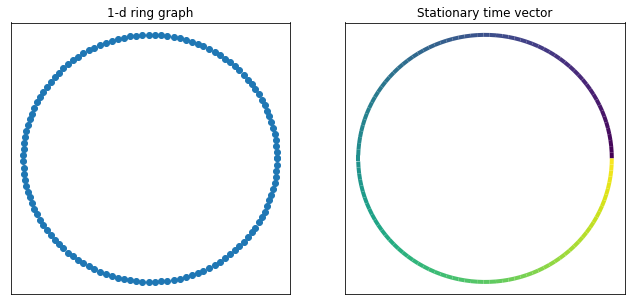

In [9]:
# Create circular graph (i.e., stationary time)
n_times = 128
time = np.linspace(0,2*np.pi,n_times)

points = np.array([np.cos(time), np.sin(time)]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#### Plotting code ####

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(time.min(), time.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)

# Set the values used for colormapping
lc.set_array(time)
lc.set_linewidth(4)

# Plot the ring graph
fig,axs = plt.subplots(1,2,figsize=(11,5))
axs[0].scatter(points[:,0,0], points[:,0,1])
axs[0].set_xticks([]), axs[0].set_yticks([]), axs[0].set_title('1-d ring graph');

axs[1].add_collection(lc)
axs[1].set_xlim([-1.1,1.1])
axs[1].set_ylim([-1.1,1.1])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Stationary time vector');

[Go back to top](#top)
<a id='laplacian'></a>
### [1.2]: The graph Laplacian.

- The Fourier Transform is a decomposition onto the eigenmodes of basic linear opertor that describes physical phenomena. 

- In the case of a diffusion process, the linear operator describing the physical phenomena is called Laplace operator, or the Laplacian $\Delta$, and it is related to the second order derivative of a signal (more concretely, to the divergence of the gradient).

$${\frac {\partial u}{\partial t}}=\Delta u $$


For discrete domains, the (normalized) graph Laplacian ($\mathbf{L}$) is defined as: 

$$\mathbf{L} = \mathbb{I}_{T} - \mathbf{D}^{-1/2}\mathbf{A}\mathbf{D}^{-1/2} $$

where:  
- $\mathbb{I}_{T} \in \mathbb~{R}^{T,T}$ is the identity matrix, 
- $\mathbf{A} \in \mathbb~{R}^{T,T}$ is the adjacency matrix of the ring-graph,
- $\mathbf{D} \in \mathbb~{R}^{T,T}$ is the degree matrix, i.e., the matrix with the sum of each row of $\mathbf{A}$ in the diagonal and zeros anywhere else. 

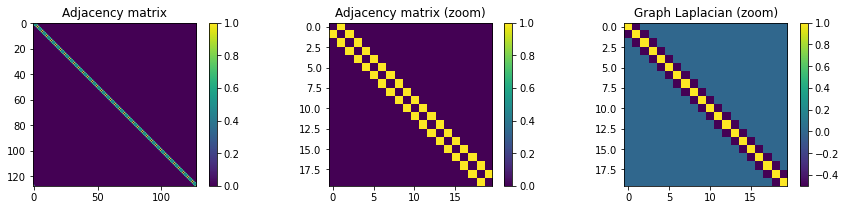

In [12]:
# This creates the adjacency matrix of a ring graph, 
# in which each node is connected only to its direct neighbors.

adjacency = np.eye(len(time),k=1) + np.eye(len(time),k=-1) 
adjacency[-1,0] = 1
adjacency[0,-1] = 1

# Compute Laplacian
aux = np.diag(np.sum(adjacency,0)**(-.5)) # D^{-1/2}
normalized_laplacian = np.eye(len(time)) - (aux)@adjacency@(aux)



#### Plotting code ####

# Plot the Adjacency and the Laplacian matrices corresponding to the ring graph
fig,axs = plt.subplots(1,3, figsize=(15,3))
im = axs[0].imshow(adjacency)
plt.colorbar(im,ax = axs[0])
axs[0].set_title('Adjacency matrix')
im = axs[1].imshow(adjacency[:20,:20])
plt.colorbar(im,ax = axs[1])
axs[1].set_title('Adjacency matrix (zoom)')
im = axs[2].imshow(normalized_laplacian[:20,:20])
plt.colorbar(im,ax = axs[2])
axs[2].set_title('Graph Laplacian (zoom)');

[Go back to top](#top)
<a id='eigdecomposition'></a>
### [1.3]: The eigendecompostion of the Laplacian.
- Due to its symmetry, the Laplacian is diagonalizable, i.e.,  it admits a decomposition onto eigenvectors and eigenvalues. 
- This decomposition is known as eigendecomposition or as spectral decomposition. 
- In the spectral decomposition, the eigenvectors, also called Fourier modes, are associated each to one eigenvalue, and the set of all eigenvalues is called the spectrum. 

[Go back to top](#top)
<a id='whatiseigdecomposition'></a>
#### [1.3.1]: What is an eigendecomposition?
It consists on finding the vectors $\mathbf{v}$ and scalar values $\lambda$ that solve this equation:

$$ \mathbf{A}\mathbf{v} = \lambda \mathbf{v}$$

Let's see what this means.


In [20]:

# Operator
A = np.array([[1.5, 0],
              [0 ,  0.5]])


origin = np.array([[0, 0, 0],[0, 0, 0]]) 

# Original vectors
vectors = np.array([[1,0], [0,1], [1.5,2]]).T

# New vectors
new_vectors = A @ vectors

# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(A)

In [21]:
def plot_eigenvectors_operator(vectors,eigenvalues,eigenvectors):
    fig,axs = plt.subplots(1,3,figsize=(15,4))
    # Plot original vectors
    axs[0].quiver(*origin, vectors[0], vectors[1], color=['r','b','g'], angles='xy', scale_units='xy', scale=1)
    axs[0].set_xlim(-.5,2.5)
    axs[0].set_ylim(-.5,2.5)
    axs[0].grid('on')
    axs[0].set_title('Original vectors')

    # Plot new vectors
    axs[1].quiver(*origin, new_vectors[0], new_vectors[1], color=['r','b','g'], angles='xy', scale_units='xy', scale=1)
    axs[1].set_xlim(-.5,2.5)
    axs[1].set_ylim(-.5,2.5)
    axs[1].grid('on')
    axs[1].set_title('Vectors after applying operator')

    # Plot new vectors
    axs[2].quiver(*origin[:,:2], eigenvectors[0], eigenvectors[1], color=['k','k'], angles='xy', scale_units='xy', scale=1)
    axs[2].set_xlim(-.5,2.5)
    axs[2].set_ylim(-.5,2.5)
    axs[2].grid('on')
    axs[2].set_title('Eigenvectors of the operator');
    axs[2].text(*eigenvectors[0],f'$\lambda_{1}$ = {eigenvalues[0]}',{'fontsize':14})
    axs[2].text(*eigenvectors[1],f'$\lambda_{2}$ = {eigenvalues[1]}',{'fontsize':14})
    print(f'Eigenvalues are : {eigenvalues}')

Eigenvalues are : [1.5 0.5]


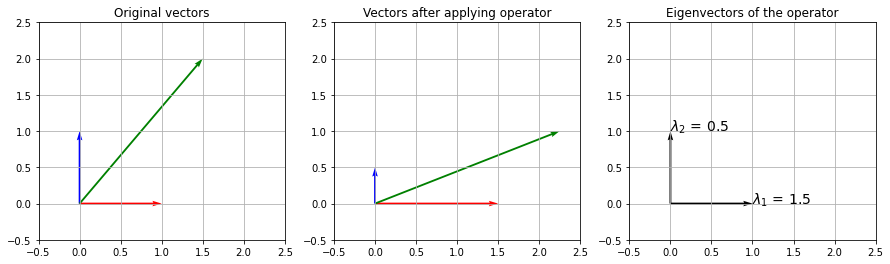

In [22]:
plot_eigenvectors_operator(vectors,eigenvalues,eigenvectors)

[Go back to top](#top)
<a id='oscillations'></a>
### [1.4]: Oscillations as Fourier modes of a ring graph

In [23]:
def plot_ring_eigenmodes(eigval, eigvect, time):
    # Plot
    plot_modes = np.linspace(0,len(time)-1,n,dtype=int)
    fig, axes = plt.subplots(2, 5, figsize=(16.6, 6.6))
    count = 0
    for j in range(2):
        for i in range(5):

            # Create a continuous norm to map from data points to colors
            norm = plt.Normalize(eigvect[:,plot_modes[count]].min(), eigvect[:,plot_modes[count]].max())
            lc = LineCollection(segments, cmap='viridis', norm=norm)

            # Set the values used for colormapping
            lc.set_array(eigvect[:,plot_modes[count]])
            lc.set_linewidth(4)

            axes[j,i].add_collection(lc)
            axes[j,i].set_xlim([-1.1,1.1])
            axes[j,i].set_ylim([-1.1,1.1])        
            axes[j,i].set_xticks([])
            axes[j,i].set_yticks([])
            axes[j,i].set_title(f'Eigvec {plot_modes[count]}')
            count+=1
    fig.tight_layout()

    # Plot 
    fig,axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].plot(abs(eigval)**2,'k')
    [axs[0].plot([i,i],[-0.1,abs(eigval[i])**2]) for i in plot_modes]
    axs[0].axhline(0,ls='--',c='k')
    axs[0].set_title('Eigvalues of graph Laplacian (Spectrum)')
    axs[0].set_xlabel('eigenvalue index (i)')
    axs[0].set_ylabel('eigenvalue ($\lambda_{i}$)')

    axs[1].plot(eigvect[::,plot_modes]+np.arange(n).T*0.5)
    axs[1].set_xlim(1,n_times-1)
    axs[1].set_title('Eigenvectors of graph Laplacian (Fourier Modes)');
    axs[1].set_xlabel('graph node index (i)')

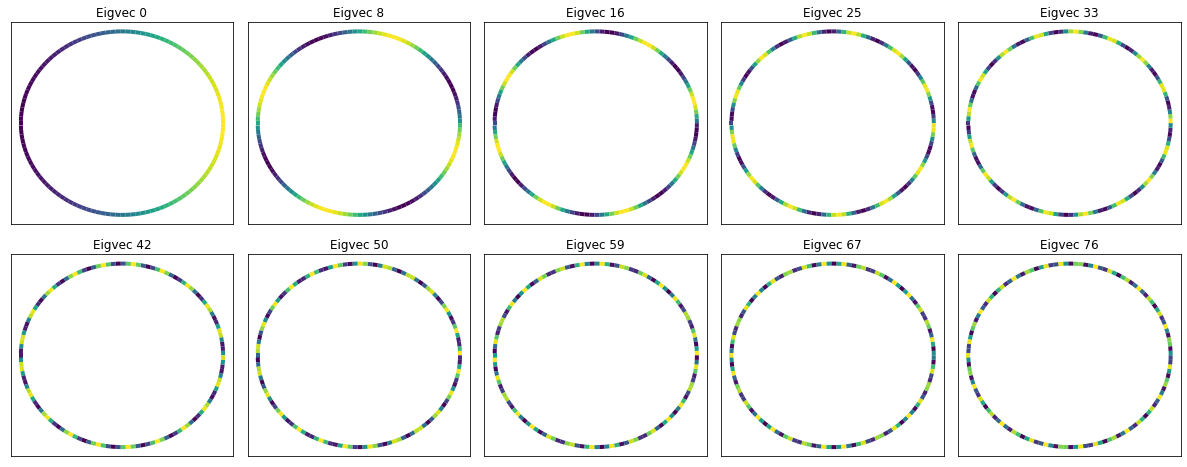

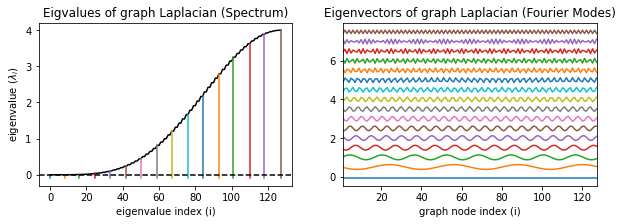

In [24]:
n = 16
# Compute Eigendecomposition and sort eigenvalue-eigenvector pairs according to smoothness
eigval, eigvect = scipy.linalg.eig(normalized_laplacian)
ids = np.argsort(eigval)
eigval, eigvect = eigval[ids], eigvect[:,ids]

plot_ring_eigenmodes(eigval, eigvect, time)

Here we have plotted the value of each graph Laplacian eigenvalue (in black), and the eigenvectors associated to 10 of these eigenvalues (in different colors). The eigenvectors, aka Fourier modes, define the spectral domain of the signal, and are vectors that vary smoothly along the ring graph. Only for illustration, we have represented them as if the graph was reshaped into a line. 
<br><br>
These variations, in the case of regular graphs such as rings, or 2-d grids (as we will see later) take the shape of oscillations. The frequency of at which the Fourier modes "oscillate" is dictated by their associated eigenvalue (its squared value). Plotting everything together we have: 

[Go back to top](#top)
<a id='dft'></a>
### [1.5]: The Discrete Fourier Transform (DFT) 

We have just constructed, and plotted, the Discrete Time Fourier basis. We are now going to define a discrete time signal (a time series), and Fourier-transform it! This is the basic principle underlying the Discrete Fourier Transform (DFT).

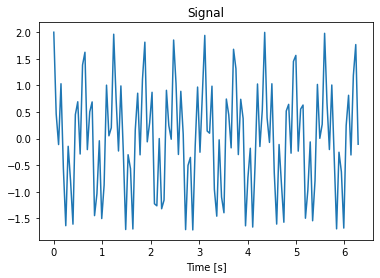

In [25]:
# Let's define a discrete signal with two main frequency components (0.5 Hz and 2 Hz)
sampling_frequency = 2*np.pi # Hz
signal_frequencies = [0.5,2] # Hz
signal = np.sum([np.cos(2 * np.pi * f * np.arange(n_times) / sampling_frequency) for f in signal_frequencies],0)
plt.plot(time,signal)
plt.xlabel('Time [s]')
plt.title('Signal');

Now let's Fourier-transform it using the spectral decomposition of the ring-graph:

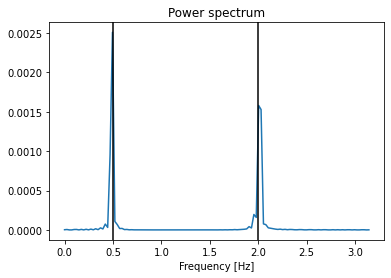

In [26]:
# Fourier transform
signal_ft = eigvect.T @ signal

# Plot the power of the signal in the spectral (frequency) domain
f_axis = np.linspace(0, sampling_frequency / 2 ,int(len(time)))[::] # Frequency axis
plt.plot(f_axis,(abs(signal_ft) / n_times)**2) 
[plt.axvline(f,c='k') for f in signal_frequencies] 
plt.xlabel('Frequency [Hz]')
plt.title('Power spectrum');

[Go back to top](#top)
<a id='pygsp'></a>
### [1.6]: *pygsp*: a Python toolbox to perform Fourier analysis on graphs.
 
This python library contains many functions and classes that will allow you to apply signal processing on different kind of graphs. We'll start by defining our ring graph, and computing its Fourier modes. All of that in only two lines of code!

In [27]:
import pygsp
ring = pygsp.graphs.Ring(N=128,lap_type='normalized')
ring.compute_fourier_basis() # <-- eigendecomposition of the graph laplacian

The *ring* object is now a *pygsp.graphs.Graph* object, and as such, it has many attributes such as: 
1. ring.N: number of nodes
2. ring.A: binary adjacency matrix
3. ring.W: weight matrix
4. ring.e: the graph spectrum (eigenvalues of the Laplacian)
5. ring.U: the Fourier basis (the columns of this matrix are the Laplacian eigenvectors). 

and functions, such as: 
1. ring.compute_fourier_basis(): computes the Laplacian eigendecomposition
2. ring.gft(x): performs the graph Fourier Transform of the signal x, i.e., left-multiplies x by the Fourier basis (x_hat = U.T@x) 
3. ring.igft(x_hat): performs the inverse graph Fourier Transform of the signal x_hat, i.e., left-multiplies x by the inverse of the Fourier basis (x = U@x_hat).

You can discover other attributes and methods of the *pygsp.graph.Graph* class has by running:

```
ring.__dir__()
```


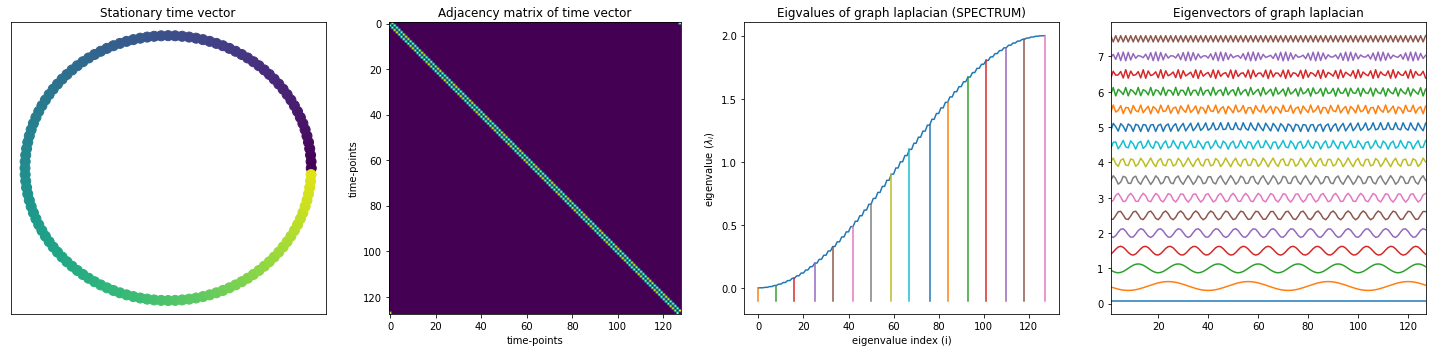

In [28]:
fig,axs = plt.subplots(1,4,figsize = (20,5))

ring.plot_signal(np.arange(n_times),ax=axs[0],colorbar=False)
axs[0].set_xlim([-1.1,1.1])
axs[0].set_ylim([-1.1,1.1])
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Stationary time vector')

axs[1].imshow(ring.A.toarray())
axs[1].set_title('Adjacency matrix of time vector')
axs[1].set_xlabel('time-points')
axs[1].set_ylabel('time-points')

axs[2].plot(ring.e)
[axs[2].plot([i,i],[-0.1,abs(ring.e[i])]) for i in np.linspace(0,len(time)-1,n,dtype=int)]
axs[2].set_title('Eigvalues of graph laplacian (SPECTRUM)')
axs[2].set_xlabel('eigenvalue index (i)')
axs[2].set_ylabel('eigenvalue ($\lambda_{i}$)')

axs[3].plot(ring.U[::,np.linspace(0,len(time)-1,n,dtype=int)]+np.arange(n).T*0.5);
axs[3].set_xlim(1,n_times-1)
axs[3].set_title('Eigenvectors of graph laplacian');
fig.tight_layout()

The Fourier transform is as simple as calling the .gft() method!

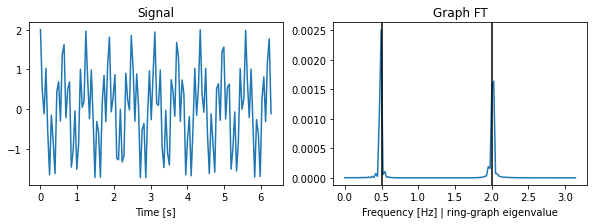

In [29]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(time,signal)
axs[0].set_xlabel('Time [s]')
axs[0].set_title('Signal')

axs[1].plot(f_axis,abs(ring.gft(signal) / n_times)**2)
[axs[1].axvline(f,c='k') for f in signal_frequencies] 
axs[1].set_xlabel('Frequency [Hz] | ring-graph eigenvalue')
axs[1].set_title('Graph FT');

[Go back to top](#top)
<a id='2dfourier'></a>

## [2]: 2D Fourier transform and 2D signal processing

Let's apply these concepts with a bit more complex, but still regular graph. We will a widely used graph in the signal processing community, the two-dimensional grid graph. We will see how this simple graph gives rise to the 2D Fourier transform, which is massively used for image processing.  
  
We can easily create a 2D-grid graph using *pygsp*:

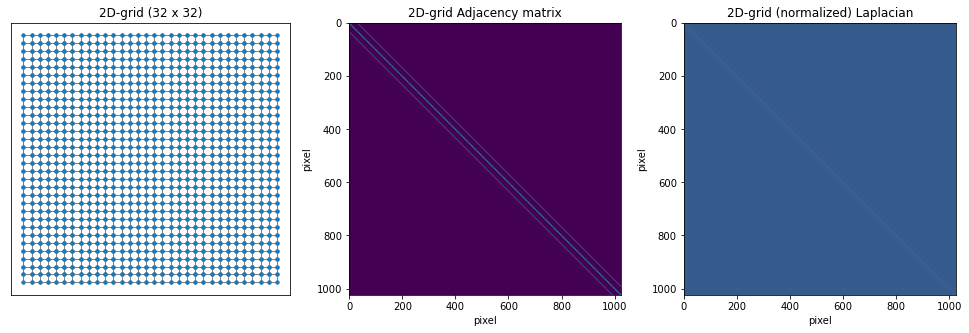

In [30]:
grid2d = pygsp.graphs.Grid2d(N1=32,N2=32, lap_type = 'normalized')
grid2d.compute_fourier_basis()

x,y = grid2d.coords.T

# plot graph its adjacency and its laplacian
fig, ax = plt.subplots(1, 3, figsize=(17,5))
grid2d.plot(vertex_size=30,ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('2D-grid (32 x 32)');

ax[1].imshow(grid2d.A.toarray())
ax[1].set_xlabel('pixel')
ax[1].set_ylabel('pixel')
ax[1].set_title('2D-grid Adjacency matrix');

ax[2].imshow(grid2d.L.toarray())
ax[2].set_xlabel('pixel')
ax[2].set_ylabel('pixel')
ax[2].set_title('2D-grid (normalized) Laplacian');

In the adjacency matrix, and the Laplacian matrix, each row and column correspond to one "node" or "pixel". The original grid is 32x32, making a total of 1024 pixels. 

[Go back to top](#top)
<a id='2dharmonics'></a>

### [2.1] The 2D-grid Fourier modes

Here we plot the 2D-grid spectrum and its Fourier modes. Remember that: 
  * the *spectrum* is given by the eigenvalues of the graph Laplacian,
  * the harmonic modes are given by the eigenvectors of the graph Laplacian.

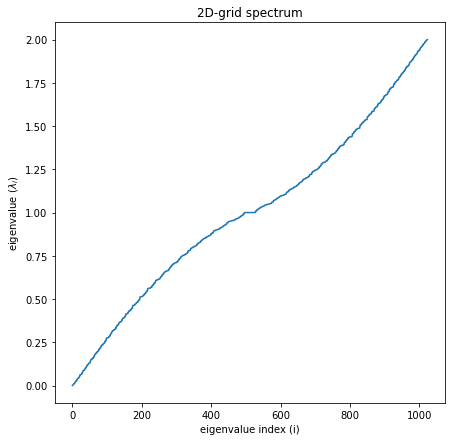

In [31]:
# plot spectrum
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(grid2d.e)
ax.set_xlabel('eigenvalue index (i)')
ax.set_ylabel('eigenvalue ($\lambda_{i}$)')
ax.set_title('2D-grid spectrum');

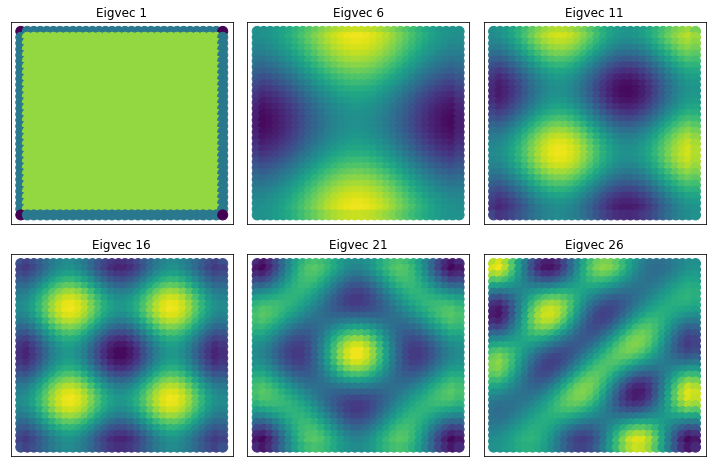

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6.6))
count = 0
for j in range(2):
    for i in range(3):
        grid2d.plot_signal(grid2d.U[:, count*5], ax=axes[j,i],colorbar=False)
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        axes[j,i].set_title(f'Eigvec {count*5+1}')
        count+=1
fig.tight_layout()

[Go back to top](#top)
<a id='connectomespectralanalysis'></a>

## [3]: Connectome Spectral Analysis

Let's apply these concepts with a bit more complex and non-regular graph, the connectome!
  
We will load the connectome from the second tutorial.

In [33]:
import scipy.io as sio
import pandas as pd

# Select resolution scale 
scale = 1

# load connectome
connectome_path = f'data/Connectome_scale-{scale}.mat'
sc_matrix = sio.loadmat(connectome_path)['num']
sc_matrix[sc_matrix!=0] = np.log(sc_matrix[sc_matrix!=0])

# Keep only cortical ROIs
roi_info_path = 'data/label/roi_info.xlsx'
roi_info = pd.read_excel(roi_info_path, sheet_name=f'SCALE {scale}')
cort_rois = np.where(roi_info['Structure'] == 'cort')[0]

# Remove subcortical ROIS: thalamus, caudate, putamen, pallidum, accumbens area
cort_rois = np.concatenate((np.arange(34),np.arange(39,75),np.arange(80,82)))

sc_matrix = sc_matrix[cort_rois][:, cort_rois]

# Get roi position 
x = np.asarray(roi_info['x-pos'])[cort_rois]
y = np.asarray(roi_info['y-pos'])[cort_rois]
z = np.asarray(roi_info['z-pos'])[cort_rois]
pos = np.concatenate((x[:,None],y[:,None],z[:,None]),1)

# Create graph object and compute fourier basis
sc = pygsp.graphs.Graph(W=sc_matrix,lap_type='normalized',coords = pos)
sc.compute_fourier_basis()

In [34]:
from utils.plotting import plot_rois

In [35]:
# Set to true to re-do the plots (it takes around 7 minutes)
if False:
    for i in range(10):
        plot_rois(sc.U[:,i],scale,label=f'FourierMode{i+1}-scale{scale}')

[Go back to top](#top)
<a id='connectomeharmonics'></a>

### [3.1]: Connectome Harmonics

Let's plot the first 10 connectome harmonics.

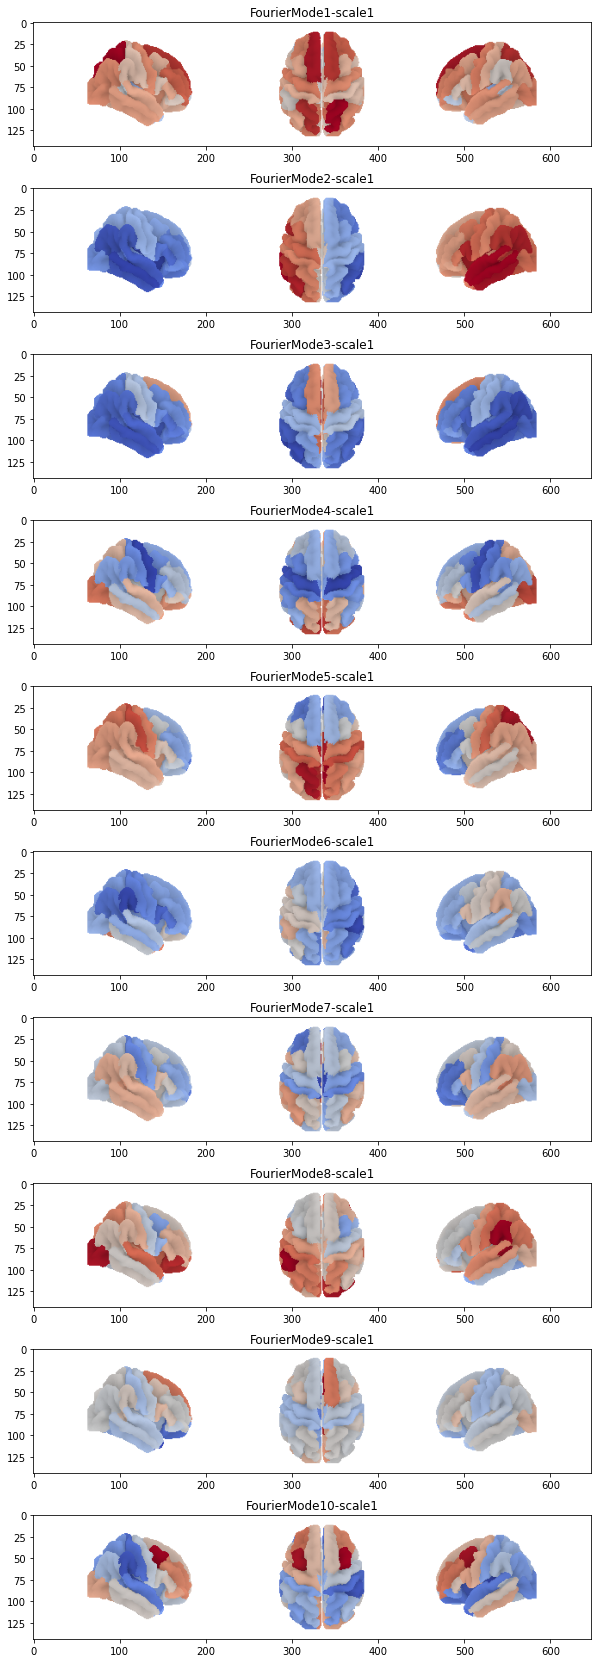

In [22]:
fig,axs = plt.subplots(10,1,figsize=(10,30))

for i in range(10):
    label = f'FourierMode{i+1}-scale{scale}'
    img = mpimg.imread(f'data/output/{label}.png')
    axs[i].imshow(img)
    axs[i].set_title(label)

[Go back to top](#top)
<a id='connectomegft'></a>

### [3.2]: Connectome Fourier transform

Now, let's load some brain activity data from the tutorial 3 and compute its connectome graph Fourier transform.

In [23]:
BIDS_folder = '/home/sinergiasummerschool/Data/ds003505'
path2esi = BIDS_folder + '/derivatives/source_modelling/sub-01/eeg/ROI_data.mat'
esidata = sio.loadmat(path2esi)['ROI_data']
trial = esidata[0,0]['trialinfo'][:,0]
time = esidata[0,0]['time'][0,0][0]
fsample = esidata[0,0]['fsample']
esi = np.asarray([elem for elem in esidata[0,0]['trial'][0]])
evoked_scrambled = esi[trial == 0].mean(0)
evoked_faces = esi[trial == 1].mean(0)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sinergiasummerschool/Data/ds003505/derivatives/source_modelling/sub-01/eeg/ROI_data.mat'

In [39]:
evoked_faces_hat = sc.gft(evoked_faces)

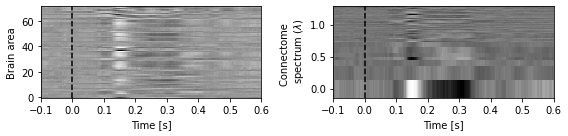

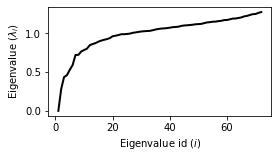

In [40]:
fig,axs = plt.subplots(1,2,figsize=(8 ,2))
ax = axs[0]
ax.pcolormesh(time,np.arange(sc.N),evoked_faces,cmap='Greys_r',shading='auto')
ax.axvline(0,ls='--',c='k')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Brain area')
ax.set_xlim(-0.1,0.6)

ax = axs[1]
ax.pcolormesh(time,sc.e,evoked_faces_hat,cmap='Greys_r',shading='auto')
ax.axvline(0,ls='--',c='k')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Connectome \n spectrum ($\lambda$)')
ax.set_xlim(-0.1,0.6)

fig.tight_layout()

fig,ax = plt.subplots(figsize=(4,2))
ax.plot(np.arange(sc.N)+1,sc.e,lw=2,c='k')
ax.set_xlabel('Eigenvalue id ($i$)')
ax.set_ylabel('Eigenvalue ($\lambda_{i}$)');


[Go back to top](#top)
<a id='extra'></a>
## [4.1] Extra material

[Go back to top](#top)
<a id='uncertainity'></a>
### [4.1] The uncertainity principle.

For further information, you can read section 2.3 of the paper https://hal.inria.fr/hal-02304584/document

In [41]:
time_analysis = (time > 0.1) & (time < 0.35)
entropy = scipy.stats.entropy(abs(evoked_faces[:,time_analysis])**2 / np.linalg.norm(evoked_faces[:,time_analysis],2,0),axis=0)
entropy_hat = scipy.stats.entropy(abs(evoked_faces_hat[:,time_analysis])**2 / np.linalg.norm(evoked_faces_hat[:,time_analysis],2,0),axis=0)

Text(0, 0.5, 'Uncertainty in the Connectome Spectrum')

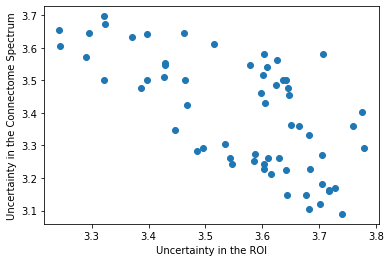

In [42]:
plt.scatter(entropy,entropy_hat)
plt.xlabel('Uncertainty in the ROI')
plt.ylabel('Uncertainty in the Connectome Spectrum')

The uncertainty principle holds here:
> The data concentration of a signal and the concentration of its Fourier transform are related and cannot be both small at the same time. 

[Go back to top](#top)
<a id='fiedler'></a>
### [4.2] The Fiedler vector: interpretation of the Fourier modes

The first Fourier mode with non-zero eigenvalue is called the Fielder vector. As it defined the smallest possible variation (non-zero eigenvalue but the closest to) it only crosses zero once, and that happens where the graph is less connected. 
<br>
Let's study this effect by creating a graph in which there is a clear region with low connectivity, for example, a graph with two densely connected communities that share few connections among them. 

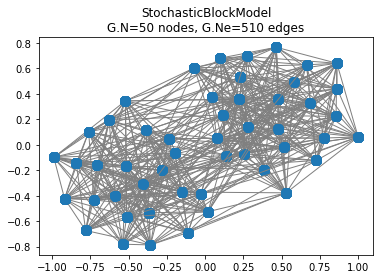

In [43]:
graph_2_communities = pygsp.graphs.StochasticBlockModel(N = 50,k=2,lap_type='normalized')
graph_2_communities.compute_fourier_basis()
graph_2_communities.set_coordinates()
graph_2_communities.plot()

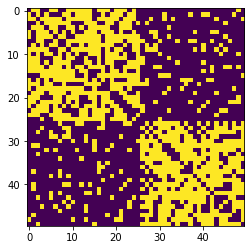

In [44]:
plt.imshow(graph_2_communities.A.todense())

The Fielder vector, i.e., the first Fourier mode corresponding to a non-zero eigenvalue, is the second Fourier mode (index 1 in Python). Lets plot it!

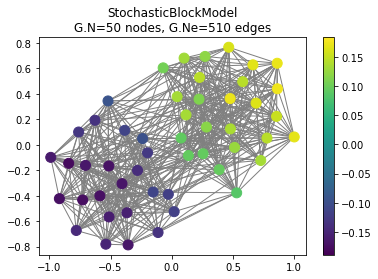

In [45]:
graph_2_communities.plot_signal(graph_2_communities.U[:,1])

In this graph made of two weakly connected communities, the two communities are represented by a different sign in the Fieldler vector. For graphs with more communities, more Fourier modes will be needed to distinguish them.

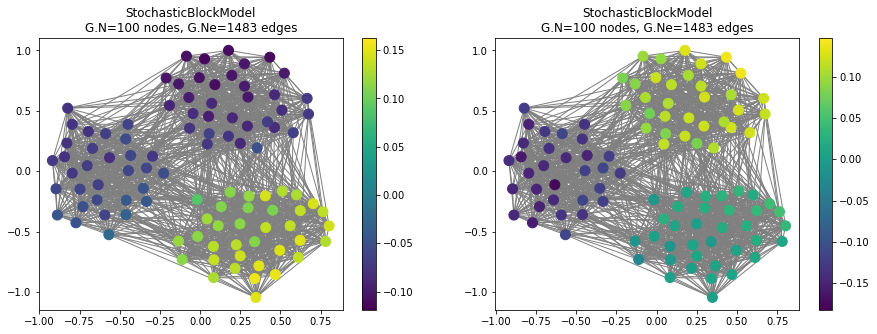

In [46]:
graph_3_communities = pygsp.graphs.StochasticBlockModel(N = 100,k=3,lap_type='normalized')
graph_3_communities.compute_fourier_basis()
graph_3_communities.set_coordinates()

fig,axs = plt.subplots(1,2,figsize=(15,5))
for i in range(2):
    graph_3_communities.plot_signal(graph_3_communities.U[:,i+1],ax=axs[i])

[Go back to top](#top)
<a id='2dsp'></a>
### [4.3] 2D signal processing
Lets do some 2D image processing! First, we need a 2D signal, for example an image of a car. Lets also plot the Fourier transform of the same image!

Text(0.5, 0, 'eigenvector id')

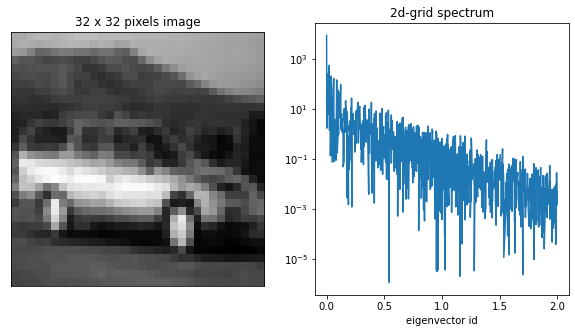

In [47]:
# Load image
img = np.load('data/car.npy')

# Compute the 2D-grid Fourier transform
img_ft = grid2d.gft(img)

fig,axs = plt.subplots(1,2,figsize = (10,5))
axs[0].imshow(img.reshape(32,32),cmap='gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('32 x 32 pixels image')

axs[1].semilogy(grid2d.e, abs(img_ft)**2 / len(img))
axs[1].set_title('2d-grid spectrum')
axs[1].set_xlabel('eigenvector id')

Now we can do some signal processing! We will start by smoothing the image. How can we do that?
We have mentioned before that the Fourier modes are ordered by smoothness, which is defined by the squared value of the associated eigenvalue. As we have seen in the previous plots, the Fourier modes corresponding to the lowest frequencies (squared Laplacian eigenvalues) are the smoothest ones. 
<br>
In order smooth the signal, we will first perform the Fourier transform, and we will filter this transformed signal by only keeping the part corresponding to the lowest Fourier modes. Then we will perform the inverse Fourier transform of this filtered signal. This type of signal processing corresponds to a low-pass filtering. Lets do it!

In [48]:
# Select an arbitrary cutoff Fourier mode for example 200
cutoff = 200

In [49]:
# Initialize the image that we want to low-pass filter 
img_ft_lp_filt = img_ft.copy()

# Remove the least smooth components
img_ft_lp_filt[cutoff:] = 0

# Perform inverse Fourier transform
img_lp_filt = grid2d.igft(img_ft_lp_filt)


# Now let's similarly perform a high-pass filtering
img_ft_hp_filt = img_ft.copy()
img_ft_hp_filt[:cutoff] = 0
img_hp_filt = grid2d.igft(img_ft_hp_filt)

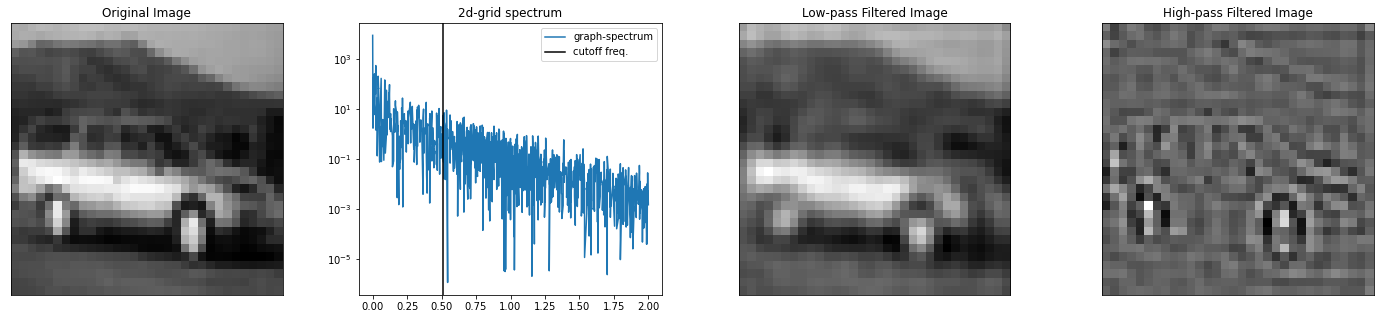

In [50]:
fig,axs = plt.subplots(1,4,figsize=(25,5))

axs[0].imshow(img.reshape(32,32),cmap='gray')
axs[0].set_title('Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].semilogy(grid2d.e,img_ft**2 / len(img),label='graph-spectrum')
axs[1].axvline(grid2d.e[cutoff],c='k',label='cutoff freq.')
axs[1].set_title('2d-grid spectrum')
axs[1].set_xlabel('')
axs[1].legend()


axs[2].imshow(img_lp_filt.reshape(32,32),cmap='gray')
axs[2].set_title('Low-pass Filtered Image')
axs[2].set_xticks([])
axs[2].set_yticks([]);

axs[3].imshow(img_hp_filt.reshape(32,32),cmap='gray')
axs[3].set_title('High-pass Filtered Image')
axs[3].set_xticks([])
axs[3].set_yticks([]);



In [ ]:
s